# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


## Tự định nghĩa Class, Function

In [2]:
class MyLogisticRegression:
    def __init__(self, eta=0.001, tol=1e-4, maxcount=1000, lamda=0.0):
        self.eta = eta
        self.tol = tol
        self.maxcount = maxcount
        self.lamda = lamda
        self.X = None
        self.y = None
        self.w = None

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def sigmoid_stable(self, s):
        if s >= 200:
            return 1
        if s <= -200:
            return 0
        return 1 / (1 + np.exp(-s))

    def calculate_w(self, X, y, w_init, eta, tol=1e-4, max_count=10000, lamda=0.0):
        w = [w_init]
        it = 0
        d = X.shape[1]
        N = X.shape[0]
        count = 0
        check_w_after = 20
        while count < max_count:
            mix_id = np.random.permutation(N)
            for i in mix_id:
                xi = X[i, :].reshape(d, 1)
                yi = y[i]
                zi = self.sigmoid_stable(np.dot(w[-1].T, xi))
                w_new = w[-1] + eta * ((yi - zi) * xi - lamda * w[-1]) # Hiệu chỉnh L2 ở đây!
                count += 1
                if count % check_w_after == 0:
                    if np.linalg.norm(w_new - w[-check_w_after]) < tol:
                        return w
                w.append(w_new)
        return w

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.X = X
        self.y = y.reshape(-1, 1)
        d = X.shape[1]
        w_init = np.random.randn(d, 1)
        self.w = self.calculate_w(X, self.y, w_init, self.eta, self.tol, self.maxcount, self.lamda)[-1]
    
    def predict(self, X_test):
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        y_pred = np.zeros(len(X_test))
        for i in range(len(X_test)):
            z = self.sigmoid_stable(np.dot(self.w.T, X_test[i]))
            y_pred[i] = 1 if z >= 0.5 else 0
        return y_pred


In [3]:
def auto_test(X_train, X_test, y_train, y_test, model=None, command='Default command'):
    from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
    import time

    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    print()
    print('=' * 20, command, '=' * 20)
    print(f'X_train: {X_train.shape}   X_test: {X_test.shape}')
    print(f'Total time: {end_time - start_time:.4f} seconds')

    print(f'Accuracy of model {model.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1-score: {f1_score(y_test, y_pred):.4f}')

    print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    print('=' * 20, command, '=' * 20)
    print()


## Chuẩn bị dữ liệu

In [4]:
df = pd.read_csv('../Dataset/archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [5]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [6]:
X = df.drop(['Attrition', 'EmployeeNumber'], axis=1)
y = df['Attrition']

In [7]:
print(f'Số bản ghi dữ liệu: {len(X)}')
print(f'Số cột dữ liệu (tập X): {len(X.columns)}')


Số bản ghi dữ liệu: 1470
Số cột dữ liệu (tập X): 33


In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# sử dụng OHE để mã hóa các categories của dữ liệu, Label Encode để mã hóa lại đầu ra của y
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
label_encoder = LabelEncoder()


In [9]:
X_origin = X.copy()
y_origin = y.copy()

In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Giả sử X_origin là DataFrame ban đầu
encode_cols = [
    'BusinessTravel', 'Department', 'Education', 'EducationField',
    'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
    'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime',
    'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
    'WorkLifeBalance'
]
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# fit chuyển đổi luôn
X_encoded_array = one_hot_encoder.fit_transform(X_origin[encode_cols]) 

# Lấy tên cột mới sau khi mã hóa
encoded_columns = one_hot_encoder.get_feature_names_out(encode_cols)

# Tạo DataFrame từ mảng mã hóa
X_encoded_df = pd.DataFrame(X_encoded_array, columns=encoded_columns, index=X_origin.index)

# Gộp với phần dữ liệu còn lại
X_encode = pd.concat([X_origin.drop(columns=encode_cols), X_encoded_df], axis=1)

In [11]:
y_encode = label_encoder.fit_transform(y)

In [12]:
X_encode

,Age,DailyRate,DistanceFromHome,EmployeeCount,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,41,1102,1,1,94,5993,19479,8,11,80,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,49,279,8,1,61,5130,24907,1,23,80,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1373,2,1,92,2090,2396,6,15,80,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,1392,3,1,56,2909,23159,1,11,80,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27,591,2,1,40,3468,16632,9,12,80,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,1,41,2571,12290,4,17,80,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,39,613,6,1,42,9991,21457,4,15,80,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,27,155,4,1,87,6142,5174,1,20,80,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,49,1023,2,1,63,5390,13243,2,14,80,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
y_encode

array([1, 0, 1, ..., 0, 0, 0], shape=(1470,))

## Dự đoán với mô hình

#### Chạy với dữ liệu gốc ban đầu đã mã hóa encode

In [14]:
X_copy_encode, y_copy_encode = X_encode.to_numpy(), y_encode

Chạy với nhiều loại train / test trong dữ liệu gốc (numpy thuần)

In [15]:
model = MyLogisticRegression(eta=0.000001, maxcount = 1000000)
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.2, random_state = 42), model = model, command = 'Chạy với dữ liệu ban đầu với test size = 0.2')


==================== Chạy với dữ liệu ban đầu với test size = 0.2 ====================
X_train: (1176, 81)   X_test: (294, 81)
Total time: 0.0680 seconds
Accuracy of model MyLogisticRegression: 0.8265
Precision: 0.0714
Recall: 0.0256
F1-score: 0.0377
Confusion matrix:
[[242  13]
 [ 38   1]]
==================== Chạy với dữ liệu ban đầu với test size = 0.2 ====================



In [16]:
model = MyLogisticRegression(eta=0.000001, maxcount = 1000000)
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.3, random_state = 42), model = model, command = 'Chạy với dữ liệu ban đầu với test size = 0.3')


==================== Chạy với dữ liệu ban đầu với test size = 0.3 ====================
X_train: (1029, 81)   X_test: (441, 81)
Total time: 0.0262 seconds
Accuracy of model MyLogisticRegression: 0.8639
Precision: 0.5385
Recall: 0.1148
F1-score: 0.1892
Confusion matrix:
[[374   6]
 [ 54   7]]
==================== Chạy với dữ liệu ban đầu với test size = 0.3 ====================



In [17]:
model = MyLogisticRegression(eta=0.000001, maxcount = 1000000)
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.4, random_state = 42), model = model, command = 'Chạy với dữ liệu ban đầu với test size = 0.4')


==================== Chạy với dữ liệu ban đầu với test size = 0.4 ====================
X_train: (882, 81)   X_test: (588, 81)
Total time: 0.0331 seconds
Accuracy of model MyLogisticRegression: 0.8622
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[507   0]
 [ 81   0]]
==================== Chạy với dữ liệu ban đầu với test size = 0.4 ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Thực nghiệm lại với sklearn

In [18]:
from sklearn.linear_model import LogisticRegression
model_2 = LogisticRegression()
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.2, random_state = 42), model = model_2, command = 'Chạy với dữ liệu ban đầu với test size = 0.2 (sklearn)')


==================== Chạy với dữ liệu ban đầu với test size = 0.2 (sklearn) ====================
X_train: (1176, 81)   X_test: (294, 81)
Total time: 0.0365 seconds
Accuracy of model LogisticRegression: 0.8571
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[252   3]
 [ 39   0]]
==================== Chạy với dữ liệu ban đầu với test size = 0.2 (sklearn) ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
model_2 = LogisticRegression()
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.3, random_state = 42), model = model_2, command = 'Chạy với dữ liệu ban đầu với test size = 0.3 (sklearn)')


==================== Chạy với dữ liệu ban đầu với test size = 0.3 (sklearn) ====================
X_train: (1029, 81)   X_test: (441, 81)
Total time: 0.0320 seconds
Accuracy of model LogisticRegression: 0.8662
Precision: 1.0000
Recall: 0.0328
F1-score: 0.0635
Confusion matrix:
[[380   0]
 [ 59   2]]
==================== Chạy với dữ liệu ban đầu với test size = 0.3 (sklearn) ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
model_2 = LogisticRegression()
auto_test(*train_test_split(X_copy_encode, y_copy_encode, test_size = 0.4, random_state = 42), model = model_2, command = 'Chạy với dữ liệu ban đầu với test size = 0.4 (sklearn)')


==================== Chạy với dữ liệu ban đầu với test size = 0.4 (sklearn) ====================
X_train: (882, 81)   X_test: (588, 81)
Total time: 0.0298 seconds
Accuracy of model LogisticRegression: 0.8571
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[504   3]
 [ 81   0]]
==================== Chạy với dữ liệu ban đầu với test size = 0.4 (sklearn) ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nhận xét: 
- Độ chính xác của việc sử dụng mô hình thuần tự xây bằng numpy và sử dụng thư viện sklearn nhìn chung cho kết quả chênh lệch không quá nhiều.
- Confusion matrix của 2 kết quả cho thấy rằng sử dụng thư viện sklearn tốt hơn một chút so với thư viện tự xây lại, tuy nhiên kết quả vẫn chưa được lắm ở cả 2 mô hình, dữ liệu vẫn bị lệch, đoán sai rất nhiều do dữ liệu ban đầu có độ lệch lớn.

Lý do cho việc ACC khá cao, tuy nhiên Confusion matrix lại có nhiều sự nhầm lẫn là vì:
- Dữ liệu đầu vào quá chênh lệch tỉ lệ `yes / no = 0.16`
- Dữ liệu đầu vào chưa được chuẩn hóa dẫn đến việc khó hội tụ.
- Bị pha loãng dữ liệu, do đầu vào ban đầu có 35 trường, sau khi sử dụng one hot encode thì số trường tăng lên là 81 trường. Kết quả có thể bị chi phối bởi các trường dữ liệu có giá trị lớn như `age`,....


#### Thực hiện với dữ liệu đã giảm chiều

##### Giảm chiều PCA

In [21]:
X = X_encode.copy()
y = y_encode.copy()

Giảm chiều theo các kích thước test/train

In [22]:
def helper(X, y, model=None, command='Default command',
           reduce_name=None, n_components=2, test_size=0.3, random_state=42):
    from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import time

    # Danh sách các cột liên tục và phân loại
    continous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount',
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
    ]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True
    )

    scaler = StandardScaler()
    X_train = X_train.copy()
    X_test = X_test.copy()

    cont_cols = [col for col in continous_data if col in X_train.columns]

    X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
    X_test[cont_cols] = scaler.transform(X_test[cont_cols])

    if reduce_name == 'PCA':
        model_rd = PCA(n_components=n_components)
        X_train = model_rd.fit_transform(X_train)
        X_test = model_rd.transform(X_test)
    elif reduce_name == 'LDA':
        model_rd = LinearDiscriminantAnalysis(n_components=n_components)
        X_train = model_rd.fit_transform(X_train, y_train)
        X_test = model_rd.transform(X_test)

    # from imblearn.over_sampling import SMOTE
    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # nếu muốn cân bằng dữ liệu khi train thì bỏ comment dòng trên 
    
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    print()
    print('=' * 20, command, f'giữ lại {n_components} chiều', '=' * 20)
    print(f'X_train: {np.shape(X_train)}, X_test: {np.shape(X_test)}')
    print(f'Total time: {end_time - start_time:.4f}s')
    print(f'Accuracy of model {model.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
    print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    print('=' * 20, command,f'giữ lại {n_components} chiều', '=' * 20)
    print()

    



**Sử dụng numpy thuần**

In [23]:
model = MyLogisticRegression(eta=0.002, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.2, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (1176, 6), X_test: (294, 6)
Total time: 13.0416s
Accuracy of model MyLogisticRegression: 0.8333
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[245   0]
 [ 49   0]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [24]:
model = MyLogisticRegression(eta=0.001, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (1029, 6), X_test: (441, 6)
Total time: 10.7297s
Accuracy of model MyLogisticRegression: 0.8163
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[360   1]
 [ 80   0]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



In [25]:
model = MyLogisticRegression(eta=0.001, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.4, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (882, 6), X_test: (588, 6)
Total time: 10.7404s
Accuracy of model MyLogisticRegression: 0.8588
Precision: 0.5000
Recall: 0.0120
F1-score: 0.0235
Confusion matrix:
[[504   1]
 [ 82   1]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



**Thực nghiệm lại với sklearn**

In [26]:
model_2 = LogisticRegression()
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.2, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (1176, 6), X_test: (294, 6)
Total time: 0.0260s
Accuracy of model LogisticRegression: 0.8197
Precision: 0.5000
Recall: 0.0189
F1-score: 0.0364
Confusion matrix:
[[240   1]
 [ 52   1]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



In [27]:
model_2 = LogisticRegression()
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (1029, 6), X_test: (441, 6)
Total time: 0.0226s
Accuracy of model LogisticRegression: 0.8617
Precision: 0.5000
Recall: 0.0164
F1-score: 0.0317
Confusion matrix:
[[379   1]
 [ 60   1]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



In [28]:
model_2 = LogisticRegression() 
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.4, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (882, 6), X_test: (588, 6)
Total time: 0.0164s
Accuracy of model LogisticRegression: 0.8435
Precision: 1.0000
Recall: 0.0213
F1-score: 0.0417
Confusion matrix:
[[494   0]
 [ 92   2]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================



##### Giảm chiều với LDA

Ở đây chúng tôi tận dụng lại một số hàm, dữ liệu đã được sử lý bên trên

**Sử dụng numpy thuần**

In [29]:
model = MyLogisticRegression(eta=0.01, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.2, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1176, 1), X_test: (294, 1)
Total time: 9.6367s
Accuracy of model MyLogisticRegression: 0.9048
Precision: 0.6471
Recall: 0.5789
F1-score: 0.6111
Confusion matrix:
[[244  12]
 [ 16  22]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



In [30]:
model = MyLogisticRegression(eta=0.001, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1029, 1), X_test: (441, 1)
Total time: 0.1798s
Accuracy of model MyLogisticRegression: 0.8889
Precision: 0.7111
Recall: 0.4706
F1-score: 0.5664
Confusion matrix:
[[360  13]
 [ 36  32]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



In [31]:
model = MyLogisticRegression(eta=0.001, maxcount = 1000000)
helper(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.4, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (882, 1), X_test: (588, 1)
Total time: 0.1683s
Accuracy of model MyLogisticRegression: 0.8690
Precision: 0.7143
Recall: 0.3571
F1-score: 0.4762
Confusion matrix:
[[476  14]
 [ 63  35]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



**Thực nghiệm lại với sklearn**

In [32]:
model_2 = LogisticRegression()
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.2, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1176, 1), X_test: (294, 1)
Total time: 0.0025s
Accuracy of model LogisticRegression: 0.8878
Precision: 0.6364
Recall: 0.5000
F1-score: 0.5600
Confusion matrix:
[[240  12]
 [ 21  21]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



In [33]:
model_2 = LogisticRegression()
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1029, 1), X_test: (441, 1)
Total time: 0.0024s
Accuracy of model LogisticRegression: 0.8912
Precision: 0.7091
Recall: 0.5493
F1-score: 0.6190
Confusion matrix:
[[354  16]
 [ 32  39]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



In [34]:
model_2 = LogisticRegression()
helper(X, y, model = model_2, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.4, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (882, 1), X_test: (588, 1)
Total time: 0.0023s
Accuracy of model LogisticRegression: 0.8673
Precision: 0.6098
Recall: 0.5208
F1-score: 0.5618
Confusion matrix:
[[460  32]
 [ 46  50]]
==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================



#### Nhận xét:

- Nhìn chung, kết quả có sự tương đồng nhất định với kết quả lần trước trong khoảng `0.8x - 0.9x`, tuy nhiên việc giảm chiều giúp dữ liệu chở nên 'gọn hơn' nhờ đó tốc độ tính toán cũng giảm đi.
- Việc giảm chiều dữ liệu bằng PCA giúp dữ liệu “gọn hơn”, giảm nhiễu và giảm thời gian huấn luyện đáng kể (thời gian chạy giảm mạnh so với dữ liệu gốc). Tuy nhiên, việc giảm chiều quá mức (ví dụ chỉ còn 6 thành phần chính) có thể làm mất nhiều thông tin quan trọng, khiến mô hình khó học được ranh giới phân tách tối ưu, dẫn đến độ chính xác thấp hơn.
- Việc chuẩn hóa dữ liệu liên tục bằng `StandardScaler` là hợp lý, vì nó giúp mô hình hội tụ nhanh hơn và tránh tình trạng các thuộc tính có giá trị lớn chi phối toàn bộ quá trình học. Điều này làm giảm khả năng overfit do chênh lệch thang đo giữa các đặc trưng.

Đánh giá overfit:
- Khi so sánh giữa tập huấn luyện và kiểm tra, ta thấy kết quả không chênh lệch quá lớn, tuy nhiên ma trận nhầm lẫn cho thấy sự phân bố không đều, đặc biệt là trong các trường hợp không giảm chiều hoặc sử dụng PCA, mô hình dự đoán nghiêng hẳn về một lớp (ví dụ ma trận [[255, 0], [39, 0]]), chứng tỏ mô hình bị lệch và có dấu hiệu overfit.
- Ngược lại, khi sử dụng LDA, tình trạng này được cải thiện hơn nhờ LDA tận dụng thông tin của nhãn trong quá trình giảm chiều, giúp tăng khả năng tách biệt giữa hai lớp.
  
- Dù vậy, vẫn còn khá nhiều phần tử nằm ngoài đường chéo chính trong ma trận nhầm lẫn, thể hiện rằng mô hình vẫn nhầm lẫn giữa hai lớp, chưa đạt mức học tổng quát tối ưu.

Biện pháp nếu nó bị overfit:
- Thêm hiệu chỉnh (L1 hoặc L2) với Logistic Regression, có thể thêm hệ số phạt ` λ‖w‖² ` (L2 regularization) để tránh trọng số tăng quá lớn.
- Giảm số chiều vừa phải
- Tăng dữ liệu huấn luyện, đảm bảo quá trình hội tụ ổn định.
- Cân bằng dữ liệu ở hai lớp 0 và 1

## Trực quan hóa

In [35]:
def helper_and_plot(X, y, model=None, command='Default command',
           reduce_name=None, n_components=2, test_size=0.3, random_state=42):
    from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import time

    # Danh sách các cột liên tục và phân loại
    continous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount',
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
    ]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True
    )

    scaler = StandardScaler()
    X_train = X_train.copy()
    X_test = X_test.copy()

    cont_cols = [col for col in continous_data if col in X_train.columns]

    X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
    X_test[cont_cols] = scaler.transform(X_test[cont_cols])

    if reduce_name == 'PCA':
        model_rd = PCA(n_components=n_components)
        X_train = model_rd.fit_transform(X_train)
        X_test = model_rd.transform(X_test)
    elif reduce_name == 'LDA':
        model_rd = LinearDiscriminantAnalysis(n_components=n_components)
        X_train = model_rd.fit_transform(X_train, y_train)
        X_test = model_rd.transform(X_test)

    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()


    def plot_prediction_vs_true(y_pred, y_test, title="So sánh Dự đoán và Thực tế"):
        y_pred = np.array(y_pred).flatten()
        y_test = np.array(y_test).flatten()
        
        plt.figure(figsize=(6, 4))
        x = np.arange(len(y_test))
        
        # Điểm đúng và sai
        correct = (y_pred == y_test)
        
        plt.scatter(x[correct], y_test[correct], color='green', label='Dự đoán đúng', marker='o')
        plt.scatter(x[~correct], y_test[~correct], color='red', label='Dự đoán sai', marker='x')
        
        plt.title(title, fontsize=14)
        plt.xlabel("Chỉ số mẫu (Index)")
        plt.ylabel("Nhãn (0/1)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    print()
    print('=' * 20, command, f'giữ lại {n_components} chiều', '=' * 20)
    print(f'X_train: {np.shape(X_train)}, X_test: {np.shape(X_test)}')
    print(f'Total time: {end_time - start_time:.4f}s')
    print(f'Accuracy of model {model.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
    print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    print('=' * 20, command, '=' * 20)
    print()

    plot_prediction_vs_true(y_pred, y_test)



==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1029, 1), X_test: (441, 1)
Total time: 0.4428s
Accuracy of model MyLogisticRegression: 0.8912
Precision: 0.7857
Recall: 0.3438
F1-score: 0.4783
Confusion matrix:
[[371   6]
 [ 42  22]]
==================== Chạy với dữ liệu đã giảm chiều ====================



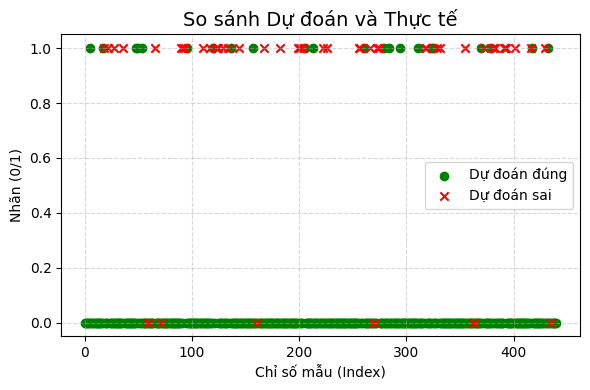

In [36]:
model = MyLogisticRegression(eta=0.0001, maxcount = 1000000)
helper_and_plot(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1029, 1), X_test: (441, 1)
Total time: 0.0022s
Accuracy of model LogisticRegression: 0.8662
Precision: 0.6818
Recall: 0.4000
F1-score: 0.5042
Confusion matrix:
[[352  14]
 [ 45  30]]
==================== Chạy với dữ liệu đã giảm chiều ====================



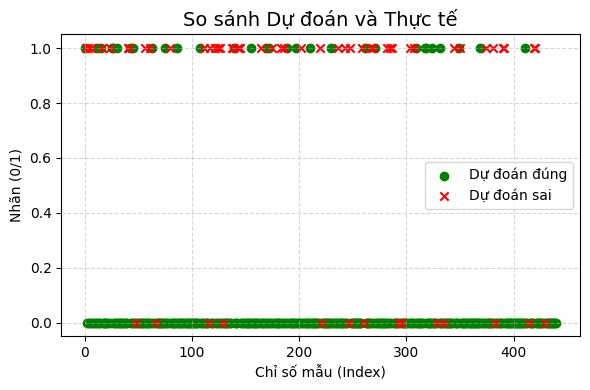

In [37]:
model = LogisticRegression()
helper_and_plot(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.3, random_state=42)

Mô hình có phù hợp hay không?

Logistic Regression là mô hình tuyến tính, có khả năng diễn giải tốt, phù hợp với dữ liệu có cả đặc trưng liên tục và phân loại (sau khi mã hóa one-hot).

Với dữ liệu có 35 thuộc tính (16 liên tục, 19 phân loại) và phân bố nhãn mất cân bằng (yes/no ≈ 0.16), mô hình Logistic Regression nhìn chung vẫn phù hợp vì đơn giản, dễ huấn luyện và cho kết quả ổn định. Tuy nhiên, ở các trường hợp không giảm chiều hoặc dùng PCA, mô hình có dấu hiệu thiên lệch về lớp đa số (no), thể hiện qua ma trận nhầm lẫn mất cân đối.

Về kết quả của mô hình, khi không giảm chiều hoặc chỉ giảm chiều bằng PCA, mô hình đạt độ chính xác khoảng 0.8x, tuy nhiên ma trận nhầm lẫn cho thấy dữ liệu phân bố không đều: mô hình có xu hướng dự đoán lớp “no” nhiều hơn, dẫn tới khả năng nhận diện lớp “yes” (thiểu số) kém hơn. Điều này xuất phát từ sự mất cân bằng trong dữ liệu (class imbalance), khiến mô hình “nghiêng” về phía lớp chiếm đa số để tối ưu hóa độ chính xác tổng thể.

![Biểu đồ so sánh dự đoán và thực tế sử dụng PCA](../assets/image/img_1.png)     

Khi sử dụng LDA (Linear Discriminant Analysis) trước Logistic Regression, kết quả cải thiện rõ rệt.
Lý do là LDA vừa giảm chiều, vừa giữ lại thông tin phân tách giữa các lớp, giúp dữ liệu sau biến đổi có ranh giới tuyến tính rõ ràng hơn. Mô hình Logistic Regression vì vậy học được ranh giới phân lớp hiệu quả hơn, giảm thiểu nhầm lẫn và cải thiện khả năng nhận diện lớp thiểu số.

![Biểu đồ so sánh dự đoán và thực tế sử dụng LDA](../assets/image/img.png)


#### Thử nghiệm lại với hiệu chỉnh


==================== Chạy với dữ liệu đã giảm chiều giữ lại 6 chiều ====================
X_train: (1029, 6), X_test: (441, 6)
Total time: 3.0348s
Accuracy of model MyLogisticRegression: 0.8231
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Confusion matrix:
[[363   0]
 [ 78   0]]
==================== Chạy với dữ liệu đã giảm chiều ====================



/media/trong-thanh/Data/University/Third Year/I/Machine Learning/Project Machine Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


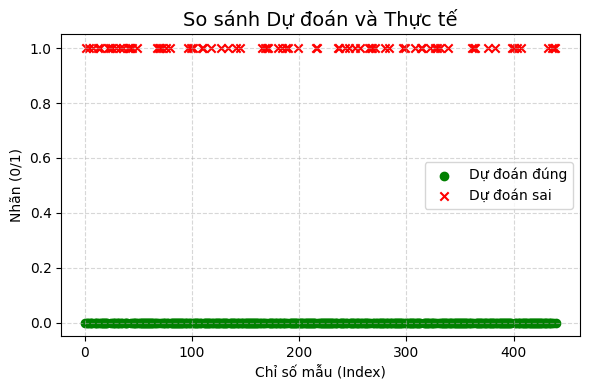

In [38]:
model = MyLogisticRegression(eta=0.0001, maxcount = 1000000, lamda = 0.1)
helper_and_plot(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'PCA', n_components = 6, test_size=0.3, random_state=42)


==================== Chạy với dữ liệu đã giảm chiều giữ lại 1 chiều ====================
X_train: (1029, 1), X_test: (441, 1)
Total time: 0.2326s
Accuracy of model MyLogisticRegression: 0.7392
Precision: 0.3581
Recall: 0.7260
F1-score: 0.4796
Confusion matrix:
[[273  95]
 [ 20  53]]
==================== Chạy với dữ liệu đã giảm chiều ====================



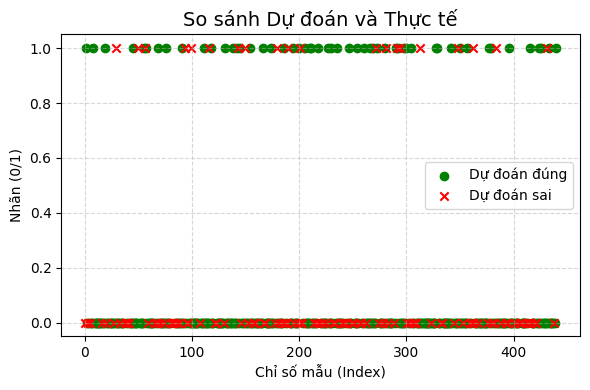

In [40]:
model = MyLogisticRegression(eta=0.0001, maxcount = 1000000, lamda = 0.1)
helper_and_plot(X, y, model = model, command = 'Chạy với dữ liệu đã giảm chiều', reduce_name = 'LDA', n_components = 1, test_size=0.3, random_state=42)

**Nhận xét**

Sau khi áp dụng các biện pháp hiệu chỉnh (regularization) cho mô hình `Logistic Regression`, mô hình trở nên ổn định hơn và giảm bớt hiện tượng overfitting so với trước ở trường hợp sử dụng `LDA`. Regularization giới hạn độ lớn của các hệ số, giúp mô hình không “học thuộc” nhiễu trong tập huấn luyện, từ đó cải thiện tính tổng quát trên tập kiểm tra.

**Tác động**

Dữ liệu lệch (class đa số >> class thiểu số). Regularization có thể làm trầm trọng vấn đề nhận diện lớp thiểu số nếu dùng một mình, Thực nghiệm (PCA + λ=0.1) cho thấy mô hình ít nhận diện được mẫu thuộc lớp thiểu số (recall rất thấp), mặc dù accuracy có vẻ cao. Điều này cho thấy accuracy không đủ để đánh giá trong trường hợp lệch lớp.

**Một số kết luận**

- Giảm overfit giảm variance, nhưng có thể tăng bias nếu regularization quá mạnh (underfitting).

- Giảm chiều giúp giảm tính phức tạp nhưng có thể loại bỏ thông tin hữu ích cho phân lớp thiểu số.

- Accuracy tăng không đồng nghĩa mô hình tốt khi dữ liệu lệch.